First we import the necessary code

In [1]:
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        # Ensure that the model dimension (d_model) is divisible by the number of heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        # Initialize dimensions
        self.d_model = d_model # Model's dimension
        self.num_heads = num_heads # Number of attention heads
        self.d_k = d_model // num_heads # Dimension of each head's key, query, and value

        # Linear layers for transforming inputs
        self.W_q = nn.Linear(d_model, d_model) # Query transformation
        self.W_k = nn.Linear(d_model, d_model) # Key transformation
        self.W_v = nn.Linear(d_model, d_model) # Value transformation
        self.W_o = nn.Linear(d_model, d_model) # Output transformation

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Calculate attention scores
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        # Apply mask if provided (useful for preventing attention to certain parts like padding)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)

        # Softmax is applied to obtain attention probabilities
        attn_probs = torch.softmax(attn_scores, dim=-1)

        # Multiply by values to obtain the final output
        output = torch.matmul(attn_probs, V)
        return output

    def split_heads(self, x):
        # Reshape the input to have num_heads for multi-head attention
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        # Combine the multiple heads back to original shape
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

    def forward(self, Q, K, V, mask=None):
        # Apply linear transformations and split heads
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))

        # Perform scaled dot-product attention
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)

        # Combine heads and apply output transformation
        output = self.W_o(self.combine_heads(attn_output))
        return output

class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)] # type: ignore

class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x


def generate_mask(tgt):
    seq_length = tgt.size(1)
    no_peek_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length, device=tgt.device), diagonal=1)).bool()
    return no_peek_mask


class DecoderTransformer(nn.Module):
    def __init__(self, output_parameter_count, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(DecoderTransformer, self).__init__()
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.fc = nn.Linear(d_model, output_parameter_count)
        self.dropout = nn.Dropout(dropout)
        self.max_seq_length = max_seq_length

    def forward(self, tgt):
        tgt_mask = generate_mask(tgt)
        tgt_embedded = self.dropout(self.positional_encoding(tgt.reshape(-1, self.max_seq_length, 1)))

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, tgt_mask)

        output = self.fc(dec_output[:, -1, :])
        return output
    
def random_values(count: int, minimum, maximum):
    return torch.rand(count) * (maximum - minimum) + minimum

def create_signals(omegas: torch.Tensor, signal_function, length: int, time_step: float, phases: torch.Tensor | None = None) -> torch.Tensor:
    count = omegas.size(0)
    waves = torch.empty(count, length)

    if phases is None:
        phases = torch.zeros(count)

    times = torch.arange(0, length) * time_step
    for i in range(count):
        wave = times * omegas[i] + phases[i]
        waves[i] = signal_function(wave)
    
    return waves

def sine(inputs: torch.Tensor) -> torch.Tensor:
    return inputs.sin()

def cosine_squared(inputs: torch.Tensor) -> torch.Tensor:
    return inputs.cos().square()

def create_batches(unbatched_list: list[torch.Tensor], batch_size: int):
    batch_count = unbatched_list[0].size(0) // batch_size
    result = []

    for unbatched in unbatched_list:
        result.append(unbatched.reshape(batch_count, batch_size, *unbatched.shape[1:]))
    
    return tuple(result)

def make_prediction(model: nn.Module, values: torch.Tensor, batch_size: int) -> torch.Tensor:
    predictions = []
    batched = create_batches([values], batch_size)[0]
    device = next(model.parameters()).device
    
    for batch in batched:
        with torch.no_grad():
            pred = model(batch.to(device)).cpu()

        predictions.append(pred)

    return torch.cat(predictions).reshape(-1)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Then we set hyperparamters and load the best trained model

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MAX_SEQUENCE_LENGTH = 512
TIME_STEP = 0.5 / MAX_SEQUENCE_LENGTH
MIN_OMEGA = 85
MAX_OMEGA = 115

best_model = DecoderTransformer(
    output_parameter_count=1,
    d_model=128,
    num_heads=16,
    num_layers=2,
    d_ff=512,
    max_seq_length=MAX_SEQUENCE_LENGTH,
    dropout=0.1
).to(device)

best_model.load_state_dict(torch.load("../models/parameter-inferrer.pt", map_location=device))
count_parameters(best_model)

396673

Then we create the evaluation data, a signal comprised of a sine wave of a varying frequency of 85 - 115 Hz and a cosine squared wave with frequency 100 Hz. Both signals also have the same phase.

In [23]:
EVAL_COUNT = 256

frequencies = random_values(EVAL_COUNT, MIN_OMEGA, MAX_OMEGA)
phases = random_values(EVAL_COUNT, 0, 2 * torch.pi)
only_100 = torch.ones(EVAL_COUNT) * 100
        
sines = create_signals(
    omegas=frequencies,
    signal_function=sine,
    length=MAX_SEQUENCE_LENGTH,
    time_step=TIME_STEP,
    phases=phases
)
    
cosines = create_signals(
    omegas=only_100,
    signal_function=cosine_squared,
    length=MAX_SEQUENCE_LENGTH,
    time_step=TIME_STEP,
    phases=phases
)
    
values = 0.7 * sines + 0.3 * cosines # we use a weighted sum to not have the signal too noisy / complex

The signal looks mostly like a sine wave, but the maximi and minimi also move in a periodic pattern, making it more complicated then a simple sine wave.

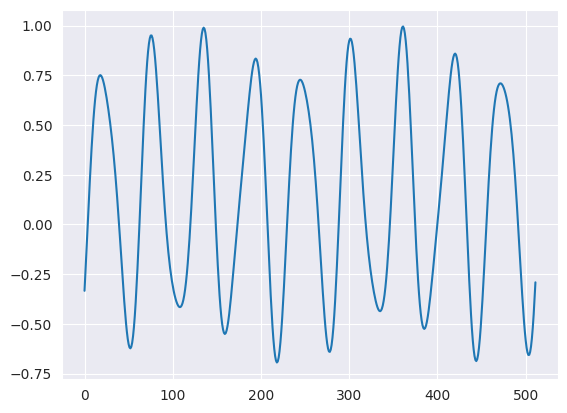

In [24]:
plt.plot(values[0])
plt.show()

Lastly, we run the values through the model and get a prediction, which we compare against the actual value.

Evaluation MAE: 0.286


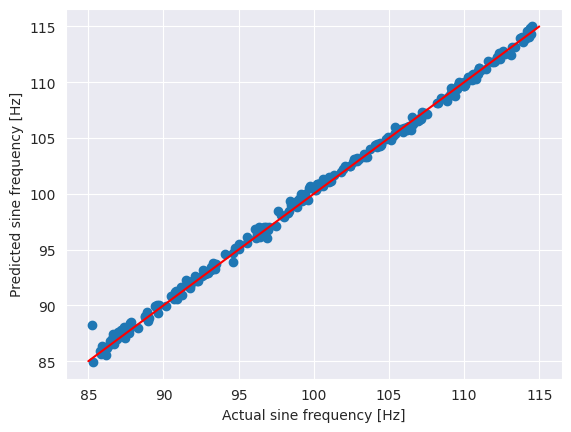

In [25]:
prediction = make_prediction(best_model, values, batch_size=16)
plt.scatter(frequencies, prediction)
plt.plot([MIN_OMEGA, MAX_OMEGA], [MIN_OMEGA, MAX_OMEGA], "r")
plt.xlabel("Actual sine frequency [Hz]")
plt.ylabel("Predicted sine frequency [Hz]")
loss = nn.L1Loss()(frequencies, prediction).item()
print(f"Evaluation MAE: {loss:.3f}")

As we can see, the average error on the frequency of (just the sine part, as the cosine part is fixed frequency) is quite small, and the scatter plot shows that there aren't any large outliers.